# Part 3: TCRex results and statistics

## 3.1: Predicting epitope specificity with TCRex

TCRex has a maximum filesize of 50000 sequences, hence larger files need to be split and uploaded separately. For this, you can use the function below, which stores the chunked dataframes in a separate `tcrex_input_chunks` folder.

In [35]:
df

,junction_aa,v_call,j_call,Total_count,Total_frequency
0,CASSNSDRTYGDNEQFF,TRBV6-2,TRBJ2-1,33422.0,2.171360e-02
1,CATSSVLTQQETQYF,TRBV24-1,TRBJ2-5,24502.0,1.591845e-02
2,CASSSRGLANTQYF,TRBV12-3,TRBJ2-3,22361.0,1.452749e-02
3,CSVVGADTYEQYF,TRBV29-1,TRBJ2-7,20930.0,1.359780e-02
4,CASSLGTALNTEAFF,TRBV7-8,TRBJ1-1,20193.0,1.311898e-02
...,...,...,...,...,...
99711,CASSPRGDPSTDTQYF,TRBV28,TRBJ2-3,1.0,6.496797e-07
99712,CASSLSGTSYEQFF,TRBV27,TRBJ2-1,1.0,6.496797e-07
99713,CSATGFSYTEQFF,TRBV20-1,TRBJ2-1,1.0,6.496797e-07
99714,CASSVGGGQALWGETQYF,TRBV19,TRBJ2-5,1.0,6.496797e-07


In [36]:
from pathlib import Path
import pandas as pd

def split_file(folder:str, file:str, chunk_size:int=50000) -> None:
    # read in the main data
    df = pd.read_csv(Path(folder, file), sep="\t", index_col=[0])
    
    # create destination path
    destination = Path(folder, "tcrex_input_chunks")
    destination.mkdir(exist_ok=True)

    # save chunked data
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        df_chunk = df.iloc[i*chunk_size:(i+1)*chunk_size]
        df_chunk.to_csv(Path(destination, f"{file.rsplit('.', 1)[0]}_{i}.tsv"), sep="\t")


Now we can chunk our data and create the input files for TCRex

In [37]:
for file in ["P1_0_parsed.tsv", "P1_15_parsed.tsv"]:
    split_file(folder="data", file=file)

These files can be uploaded to the TCRex webserver: https://tcrex.biodatamining.be/

Here, you will need to select the epitopes of interest, and TCRex will predict which sequences in your dataset could possibly interact with these epitopes. More information and a detailed manual can be found [here](https://tcrex.biodatamining.be/instructions/). After running these predictions, the result files can be downloaded and place in the `tcrex_results` folder.

Once again, we will need the `pandas` library for handling the data. In addition, this part of the tutorial requires the `scipy`  and `statsmodels` libraries.

## 3.2: Statistical analysis of epitope prediction results

We will place all TCRex result files in the same folder. The following functions will read in all files in this folder, and parse them accordingly. This will return a dataframe with all TCRex annotations.

In [80]:
import os
from itertools import islice

def extract_filename(file) -> str:
    """Extracts the original filename from the TCRex output header
    """
    with open(file) as f:
        for l in (islice(f, 1,2)):
            return l.split("\t")[-1].rsplit("_", 1)[0]
    

def read_tcrex_output_files(folder) -> pd.DataFrame:
    """Reads in all TCRex result files in a given folder. Adds a column with the filename origin.
    """
    dfs = []
    for file in os.listdir(folder):
        df = pd.read_csv(Path(folder, file), sep = "\t", comment = "#")
        df["file"] = extract_filename(Path(folder, file))
        dfs.append(df)

    return pd.concat(dfs).sort_values(by=["file", "score"], ascending=[True, False])

In [85]:
read_tcrex_output_files("data/tcrex_results/")

,TRBV_gene,CDR3_beta,TRBJ_gene,epitope,pathology,score,bpr,file
0,TRBV07-03,CASSLSGASTDTQYF,TRBJ02-03,FLNGSCGSV,SARS-CoV-2,1.00,0.00000,P1_0_parsed
1,TRBV29-01,CSVEGGTGSSYNEQFF,TRBJ02-01,TPINLVRDL,SARS-CoV-2,1.00,0.00000,P1_0_parsed
2,TRBV29-01,CSVEGSGGSSYNEQFF,TRBJ02-01,TPINLVRDL,SARS-CoV-2,1.00,0.00000,P1_0_parsed
3,TRBV29-01,CSVEGASGSTYNEQFF,TRBJ02-01,TPINLVRDL,SARS-CoV-2,1.00,0.00000,P1_0_parsed
161,TRBV14,CASSQSPGGTQYF,TRBJ02-03,GLCTLVAML,EBV,1.00,0.00001,P1_0_parsed
...,...,...,...,...,...,...,...,...
1098,TRBV06-01,CASMASGFSNTGELFF,TRBJ02-02,QVPLRPMTYK,HIV,0.49,0.00009,P1_15_parsed
1099,TRBV05-01,CASSFDRGSGNTIYF,TRBJ01-03,QVPLRPMTYK,HIV,0.49,0.00009,P1_15_parsed
3276,TRBV27,CASGKYNEQFF,TRBJ02-01,QVPLRPMTYK,HIV,0.49,0.00009,P1_15_parsed
3277,TRBV12-03,CASSPDRGSGNTIYF,TRBJ01-03,QVPLRPMTYK,HIV,0.49,0.00009,P1_15_parsed


In [90]:
import numpy as np

from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
from matplotlib.cm import ScalarMappable

We will perform a simple quantitative evaluation of the TCRex prediction results by calculating the identification rate and an enrichment score for a certain epitope. The identification rate describes the percentage of epitope-specific TCRs TCRex found in a repertoire (i.e. the number of TCRs for which a hit was found). To calculate the enrichment score, we perform a one-sided binomial test to assess significant overrepresentation (enrichment) of a particular epitope in a sample.

In [111]:
def identification_rate(nr_identified, repertoire_size):
    
    """
    Calculate the percentage of epitope-specific TCRs in a repertoire.
    
    Args:
    - nr_identified: The number of identified epitope-specific TCRs 
    - repertoire_size: The number of TCRs in the original repertoire, reported on the TCRex results page
    
    """
    return (nr_identified / repertoire_size) * 100

def enrichment_analysis(
    nr_identified: int, 
    repertoire_size: int, 
    threshold: float = 0.001
    ):
    """
    Calculate the p value of a one sided binomial test.

    Args:
    - nr_identified:  The number of identified epitope-specific TCRs 
    - repertoire_size: The number of TCRs in the original repertoire, reported on the TCRex results page
    - enrichment_threshold: Probability of success as defined in a binomial test.

    """
    return binomtest(
         k = nr_identified, 
         n = repertoire_size,
         p = threshold,
         alternative = 'greater'
         )

Using the following sequence of commands, we can calculate the quantitative metrics that we defined previously. That is, for a single epitope. Here, we will illustrate this using the epitope 'FLKEKGGL'.

In [183]:
# Read the resuls
tcrex_results = read_tcrex_output_files('data/tcrex_results')
tcrex_results_epitope = tcrex_results[tcrex_results.epitope == "FLKEKGGL"]

# Calculate the number of identified epitope-specific TCRs 
nr_identified = tcrex_results_epitope.shape[0]  

# Define the repertoire size
repertoire = pd.read_csv('data/P1_0_parsed.tsv', sep = '\t')
repertoire_size = repertoire.shape[0]

p = enrichment_analysis(nr_identified, repertoire_size).pvalue # p-value
ir = identification_rate(nr_identified, repertoire_size) # identification rate

# Calculate the identification metrics
print(f"result: {p}")
print(f"Identification rate: {ir}")

result: 1.0
Identification rate: 0.02578143530406625


Most of the time, however, we use multiple TCRex epitope models. Therefore, we should calculate the enrichment score for each epitope individually. The following function does this by looping through every epitope in the results file.

In [135]:
def calculate_metrics(
    results: pd.DataFrame, 
    repertoire_size: int, 
    threshold: float,
    mtc: bool = True
    ):
    """
    Calculate the identification rate and enrichment analysis p value for every epitope in a TCRex results file.
    
    Args:
    - results: Pandas DataFrame containing the TCRex results
    - repertoire_size: The number of TCRs in the original repertoire, reported on the TCRex results page
    - enrichment_threshold: Probability of success as defined in a binomial test.
    - mtc: p-value correction for multiple tests using Benjamini-Hochberg method for controlling FDR.
    """
    # For every epitope, store the calculated metrics in a dictionary
    cols = ["epitope", "pathology", "identification_rate", "p_value"]
    metrics = pd.DataFrame(columns = cols)
    
    # Loop through epitopes
    for epitope in results.epitope.unique():
        # Retrieve all TCRs specific for the epitope
        epitope_data = results[results['epitope'] == epitope]
        pathology = epitope_data.pathology.iloc[0]
        # Calculate the number of epitope-specific TCRs
        nr_identified = epitope_data.shape[0]
        # Calculate metrics
        ir = identification_rate(nr_identified, repertoire_size)
        p = enrichment_analysis(nr_identified, repertoire_size, threshold).pvalue
        # Add to dataframe
        metrics = pd.concat([metrics, pd.DataFrame([[epitope, pathology, ir, p]], columns = cols)])
        
    if mtc:
        # Calculate corrected p-values
        p_adj = multipletests(
            pvals = metrics["p_value"], 
            method = 'fdr_bh', 
            is_sorted = False
            )[1]
        # Add to dataframe
        metrics['adjusted_p_value'] = p_adj
        
    return metrics 

Next, we define a function for plotting the epitope distribution of each repertoire as a bar chart with annotated labels.

In [152]:
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

def plot_epitope_distribution(
    metrics_df: pd.DataFrame,
    name: str,
    colordict: dict,
    y_value: str = "identification_rate",
    y_axis: str = "Identification rate (%)",
    title: str = None,
    plot_legend = True,
    ax = None,
    ):

    if not ax:
        ax = plt.gca()
    
    # Sort data with respect to target attribute
    metrics_df = metrics_df.sort_values(by = y_value, ascending = False)

    # Map colors to labels
    metrics_df["colors"] = metrics_df.pathology.map(colordict)
    
    # Bar plot
    ax.bar(
        x = metrics_df.epitope, # x values
        height = metrics_df[y_value], # y values
        color = metrics_df.colors # color labels
        )
    
    # Plot the names of the epitopes
    _ = ax.set_xticklabels(
        metrics_df.epitope, 
        rotation = 90, 
        fontsize = 8
        )

    # Axis labels
    ax.set_xlabel("epitopes")
    ax.set_ylabel(y_axis)
    ax.set_title(title)
    
    if plot_legend:
        # Set up figure legend
        handles = [mpatches.Patch(color=colordict[i]) for i in colordict]
        labels = [i for i in colordict]
        ax.legend(handles, labels, fontsize=6)

    return ax


Finally, we can put all this together and calculate some the statistics we just defined for every individual epitope for which we screened.

### **Calculate statistics for P1 at day 0**

In [215]:
# Read the resuls
results_day_0 = read_tcrex_output_files('data/tcrex_results').query("file == 'P1_0_parsed'")

# Define the repertoire size
repertoire_day_0 = pd.read_csv('data/P1_0_parsed.tsv', sep = '\t')
repertoire_size_day_0 = repertoire_day_0.shape[0]

# Calculate metrics for epitopes
metrics_day_0 = calculate_metrics(
    results = results_day_0,
    repertoire_size = repertoire_size_day_0,
    threshold = 0.001
    )

# Show results
metrics_day_0.sort_values(by = 'adjusted_p_value')

,epitope,pathology,identification_rate,p_value,adjusted_p_value
0,ELAGIGILTV,Melanoma,1.070445,0.000000e+00,0.000000e+00
0,NLVPMVATV,CMV,1.452010,0.000000e+00,0.000000e+00
0,TPQDLNTML,HIV,0.964226,0.000000e+00,0.000000e+00
0,TLIGDCATV,SARS-CoV-2,0.398065,1.541085e-108,3.775658e-107
0,ILHCANFNV,SARS-CoV-2,0.231002,2.251000e-28,4.411961e-27
...,...,...,...,...,...
0,FLPRVFSAV,SARS-CoV-2,0.049500,1.000000e+00,1.000000e+00
0,LPRRSGAAGA,Influenza,0.043313,1.000000e+00,1.000000e+00
0,RFYKTLRAEQASQ,HIV,0.018563,1.000000e+00,1.000000e+00
0,KLSYGIATV,SARS-CoV-2,0.026813,1.000000e+00,1.000000e+00


### **Calculate statistics for P1 at day 15**

In [216]:
# Read the resuls
results_day_15 = read_tcrex_output_files('data/tcrex_results').query("file == 'P1_15_parsed'")

# Define the repertoire size
repertoire_day_15 = pd.read_csv('data/P1_15_parsed.tsv', sep = '\t')
repertoire_size_day_15 = repertoire_day_15.shape[0]

# Calculate metrics for epitopes
metrics_day_15 = calculate_metrics(
    results = results_day_15,
    repertoire_size = repertoire_size_day_15,
    threshold = 0.001
    )

# Show results
metrics_day_15.sort_values(by = 'adjusted_p_value').head(10)

,epitope,pathology,identification_rate,p_value,adjusted_p_value
0,NLVPMVATV,CMV,1.159609,0.000000e+00,0.000000e+00
0,ELAGIGILTV,Melanoma,1.028219,0.000000e+00,0.000000e+00
0,TPQDLNTML,HIV,0.819682,0.000000e+00,0.000000e+00
0,TLIGDCATV,SARS-CoV-2,0.312202,7.486755e-54,1.834255e-52
0,ILHCANFNV,SARS-CoV-2,0.191661,7.953592e-14,1.558904e-12
0,NQKLIANQF,SARS-CoV-2,0.018081,1.000000e+00,1.000000e+00
0,IVTDFSVIK,EBV,0.018081,1.000000e+00,1.000000e+00
0,TLVPQEHYV,SARS-CoV-2,0.014465,1.000000e+00,1.000000e+00
0,LLFNKVTLA,SARS-CoV-2,0.037368,1.000000e+00,1.000000e+00
0,FLKEKGGL,HIV,0.015670,1.000000e+00,1.000000e+00


Next, we will prepare the color labels to annotate the epitope distribution bar charts (function defined previously).

In [217]:
from matplotlib import cm

# Get colors
cmap = cm.get_cmap('tab20') # choose colormap
colors = cmap.colors # extract colors

pathologies = set(metrics_day_0.pathology).union(set(metrics_day_15.pathology))
colorlabels = dict(zip(pathologies, colors[:len(pathologies)]))

/tmp/ipykernel_16165/1078117628.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20') # choose colormap


### **Plot epitope distribution for P1 at day 0**

/tmp/ipykernel_16165/2066591773.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(


<Axes: title={'center': 'Identification rate of epitope-specific TCRs at day 0'}, xlabel='epitopes', ylabel='Identification rate (%)'>

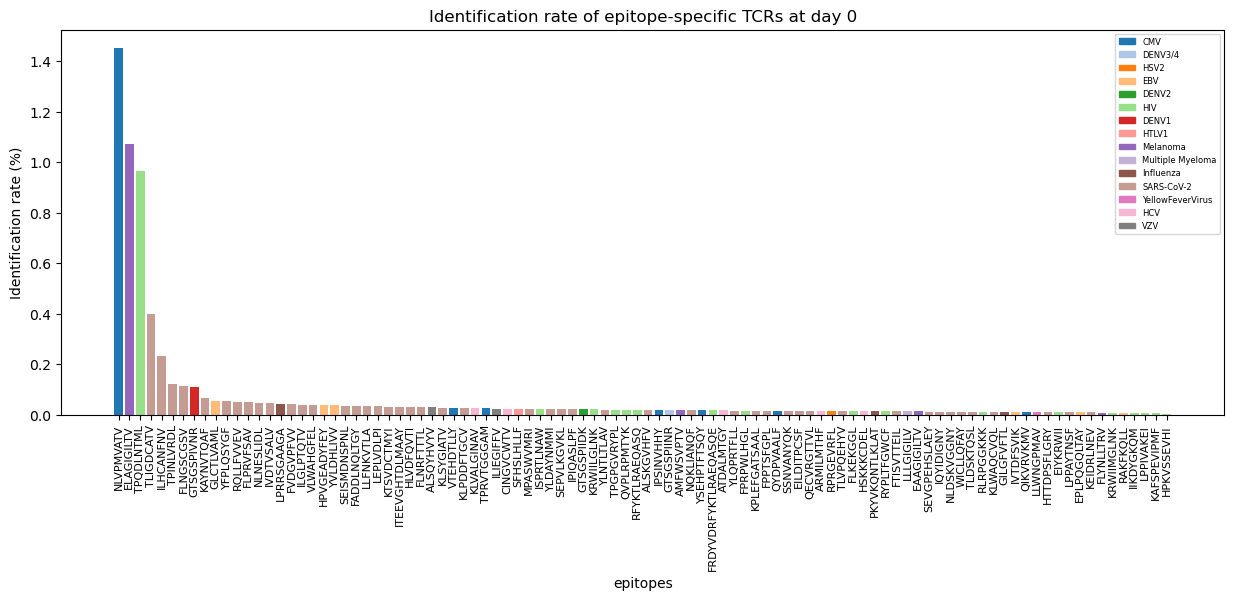

In [218]:
fig, ax = plt.subplots(figsize = (15,5))

plot_epitope_distribution(
    metrics_df = metrics_day_0, 
    colordict = colorlabels, 
    name = 'P1_0_epitope_distribution',
    title = "Identification rate of epitope-specific TCRs at day 0",
    ax=ax
    )

### **Plot epitope distribution for P1 at day 15**

/tmp/ipykernel_16165/2066591773.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(


<Axes: title={'center': 'Identification rate of epitope-specific TCRs at day 15'}, xlabel='epitopes', ylabel='Identification rate (%)'>

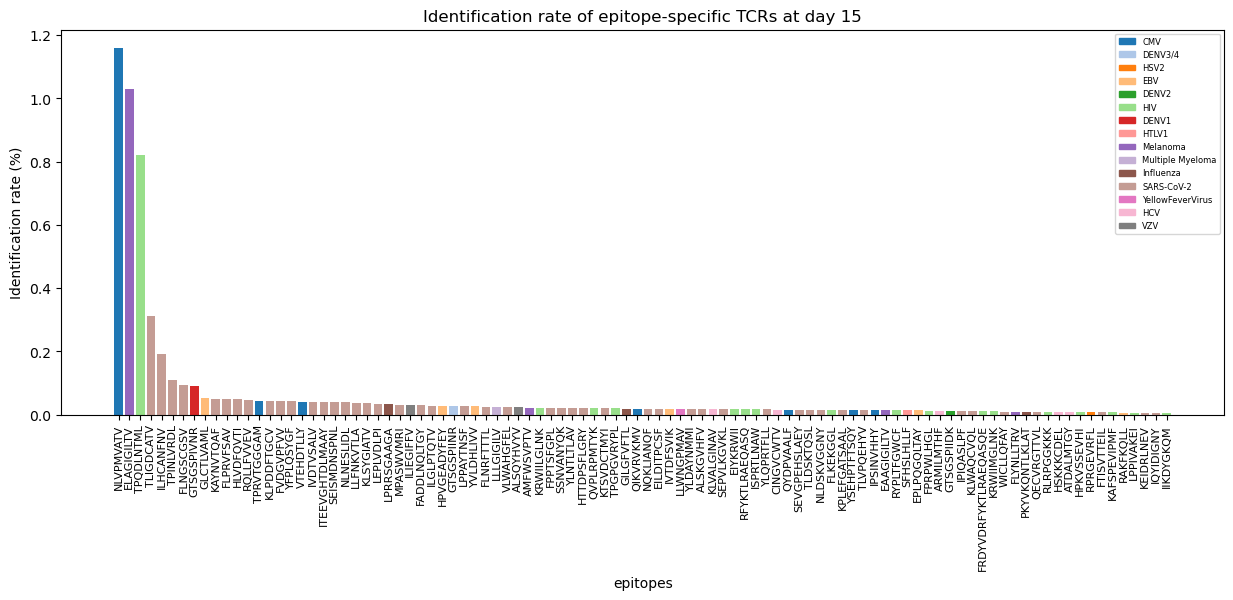

In [219]:
fig, ax = plt.subplots(figsize = (15,5))

plot_epitope_distribution(
    metrics_df = metrics_day_15, 
    colordict = colorlabels, 
    name = 'P1_15_epitope_distribution',
    title = "Identification rate of epitope-specific TCRs at day 15"
    )

Next, we will calculate the fold change in epitope-specific TCR expression between day 0 and day 15. This will give an indication of which TCRs have expanded (or contracted) between two matched repertoires.

In [220]:
metrics = metrics_day_0.merge(right = metrics_day_15, on = ["epitope", "pathology"], how = "outer")

# We need to make some adjustments to these columns
ir_cols = ["identification_rate_x", "identification_rate_y"]
p_cols = ["p_value_x", "p_value_y", "adjusted_p_value_x", "adjusted_p_value_y"]

# Fill NAs identification rate with 0
# Normalize with minimum identification rate to prevent division by zero
metrics[ir_cols] = metrics[ir_cols].fillna(0) + metrics[ir_cols].min()
# Fill NAs p values rate with 0
metrics[p_cols] = metrics[p_cols].fillna(1)

# # Calculate fold change (B/A)
metrics["ir_fold_change"] = metrics["identification_rate_y"] / metrics["identification_rate_x"]
metrics["ir_fold_change"] = np.log2(metrics["ir_fold_change"].astype(float))

metrics.head()

,epitope,pathology,identification_rate_x,p_value_x,adjusted_p_value_x,identification_rate_y,p_value_y,adjusted_p_value_y,ir_fold_change
0,FLNGSCGSV,SARS-CoV-2,0.114470,0.142744,1.000000,0.097639,0.758180,1.0,-0.229441
1,TPINLVRDL,SARS-CoV-2,0.123751,0.026235,0.428501,0.115720,0.173414,1.0,-0.096803
2,GLCTLVAML,EBV,0.057750,1.000000,1.000000,0.056654,0.999999,1.0,-0.027641
3,YLQPRTFLL,SARS-CoV-2,0.018563,1.000000,1.000000,0.021697,1.000000,1.0,0.225125
4,GILGFVFTL,Influenza,0.013406,1.000000,1.000000,0.022903,1.000000,1.0,0.772613


Finally, we can plot the results.

/tmp/ipykernel_16165/2066591773.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(


<Axes: title={'center': 'Identification rate fold change per epitope (day 0 vs 15)'}, xlabel='epitopes', ylabel='$\\log_{2}(IR-FC)$'>

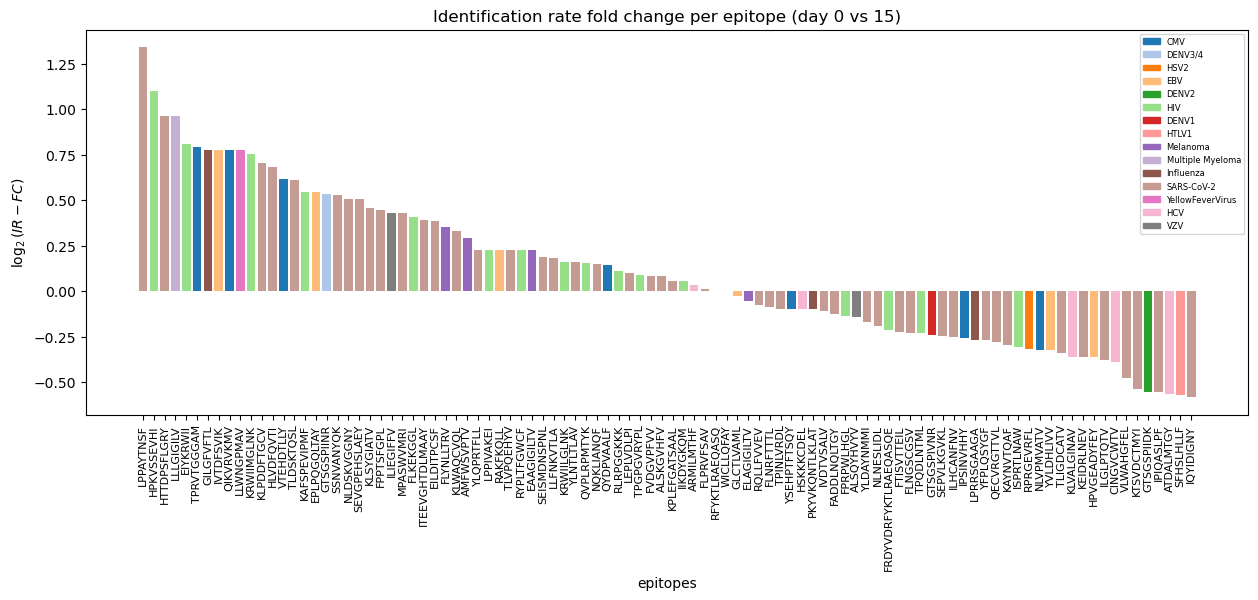

In [221]:
fig, ax = plt.subplots(figsize=(15,5))

plot_epitope_distribution(
    metrics_df = metrics, 
    name = "epitope_fold_change_epitopes",
    colordict = colorlabels,
    y_value = "ir_fold_change",
    y_axis = r"$\log_{2}(IR-FC)$", # IR-FC = identification rate fold change
    title = 'Identification rate fold change per epitope (day 0 vs 15)'
    )

/tmp/ipykernel_16165/2089382785.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation = 90)


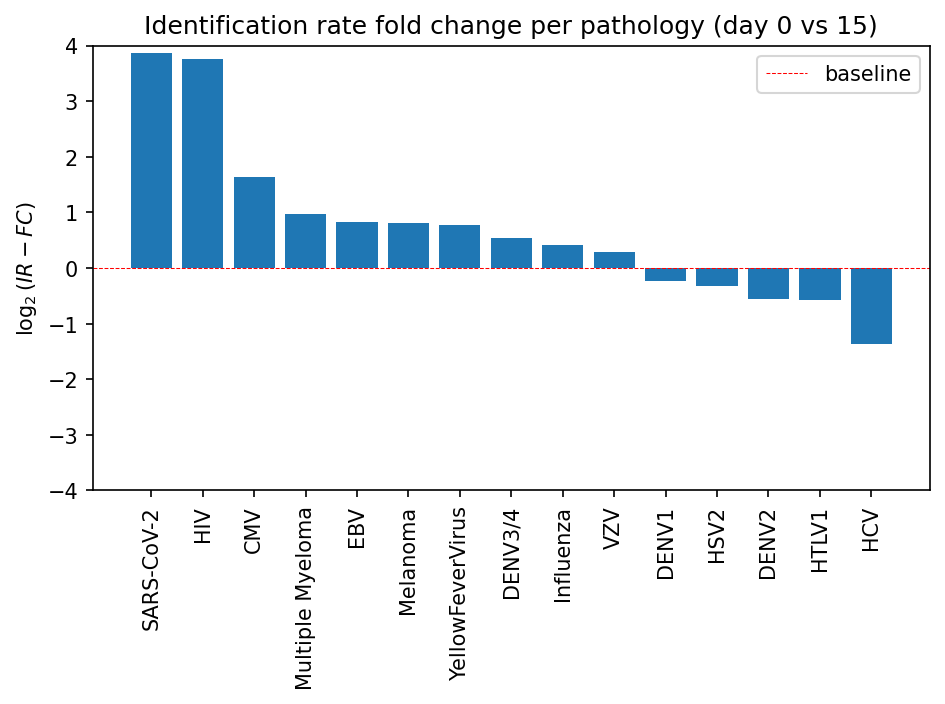

In [222]:
pathology_grouped = metrics.groupby('pathology').ir_fold_change.sum()
pathology_grouped = pathology_grouped.sort_values(ascending = False)

fig, ax = plt.subplots(dpi = 150)

x = pathology_grouped.index
y = pathology_grouped

ax.bar(x = x, height = y)
ax.axhline(y = 0, c = 'r', ls = '--', lw = .5, label = 'baseline')
ax.set_ylabel(r'$\log_{2}(IR-FC)$')
ax.set_xticklabels(x, rotation = 90)
ax.set_title('Identification rate fold change per pathology (day 0 vs 15)')
ax.set_ylim(-4, 4)
ax.legend()

fig.tight_layout()

#fig.savefig('./results/figures/ir_fold_change_pathologies.png', format = 'png', bbox_inches = 'tight')